# New filter implementation

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
import time
import os
import sys
from collections import defaultdict
import pandas as pd

import torch
import torch.nn as nn
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from numpy.lib.stride_tricks import sliding_window_view
from functools import partial


In [2]:
sys.path.append("../")

from nn.dataset import NetDataset
from nn.net import Net
from nn.config import DATA_PATH, OBJECTS, STRIDE, KERNEL_SIZE, INPUT_SIZE, N_CHANNELS, HID_DIM

from utils.load_multi_array import load_multi_array
from utils.data_load import load_data, get_labeled_data, dict_map, get_non_zero_ratio
from utils.plot_light_curve import plot_curves

In [3]:
data_raw = load_data(DATA_PATH)
cylinder_data = get_labeled_data(data_raw, OBJECTS["cylinder"])

Folder c:/Users/danok/work/dizertacka/resources/Fall_2021_2: 100%|██████████| 495/495 [00:05<00:00, 83.35it/s] 


## Filter $\rightarrow$ based on bins

1) Divide light curve into N bins
2) Determine if bin contains signal

Now we can use different stategies:
1) All bins contain signal
2) Not all bins contain signal:
    - Choose size of gap: how many bins can be empty
    - Choose size of continous gap: how many bins in a row can be empty



In [4]:
stats = dict_map(cylinder_data, get_non_zero_ratio)

In [5]:


def get_filter_continuous(data, n_bins=10, gap=0, continous_gap=3):
    N = 300 // n_bins

    x = np.resize(data, (data.shape[0], n_bins, N))
    bins = np.sum(x, axis=2) != 0
    bins_sum = np.sum(bins, axis=1)

    res = bins_sum >= (n_bins - gap)

    if continous_gap > 0:
        continous_gaps = sliding_window_view(bins, window_shape=continous_gap, axis=1)
        continous_gaps_ok = np.all(np.sum(continous_gaps, axis=2) != 0, axis=1)

        res = np.logical_and(res, continous_gaps_ok)

    return res

def get_filter_ratio(data, ratio=0.5):

    x = np.sum(data != 0, axis= 1) / 300
    return x >= ratio

def apply_filters(data, filters_f, operation="AND"):

    f_res = None

    for f in filters_f:
        if f_res is None:
            f_res = f(data)
        else:
            if operation == "AND":
                f_res = np.logical_and(f(data), f_res)
            else:
                print(":)")
                f_res = np.logical_or(f(data), f_res)
    
    return data[f_res]


In [6]:
d = cylinder_data["atlas_5"]

In [7]:
x = get_filter_continuous(d, n_bins=10, gap=0, continous_gap=0)
y = get_filter_ratio(d, ratio=0.5)

print(x.shape, np.sum(x))

(19509,) 10655


### Visualisation

In [8]:
def sort_func(arr):
    stats = np.sum(arr != 0, axis=1)
    indices = np.argsort(-stats)
    return arr[indices]

def get_representants(arr):

    best = arr[:3]
    worst = arr[-3:]

    mid = len(arr)//2
    middle = arr[mid-1:mid+2]

    data = np.concatenate((best, middle, worst))
    titles = [f'Signal ratio: {x/300 * 100:.2f}%' for x in np.sum(data != 0, axis=1)]

    return data, titles


def get_stats(arr):
    stats = np.sum(arr != 0, axis=1) / 300 * 100
    return stats

In [9]:
labeled_data = dict_map(cylinder_data, sort_func)

f_continous = partial(get_filter_continuous, n_bins=15, gap=0, continous_gap=0)
f_ratio = partial(get_filter_ratio, ratio=0.2)
app_filters_p = partial(apply_filters, filters_f=[f_continous, f_ratio], operation="AND")

filtered_data = dict_map(labeled_data, app_filters_p)

f_stats = dict_map(filtered_data, get_non_zero_ratio)


representants = dict_map(filtered_data, get_representants)


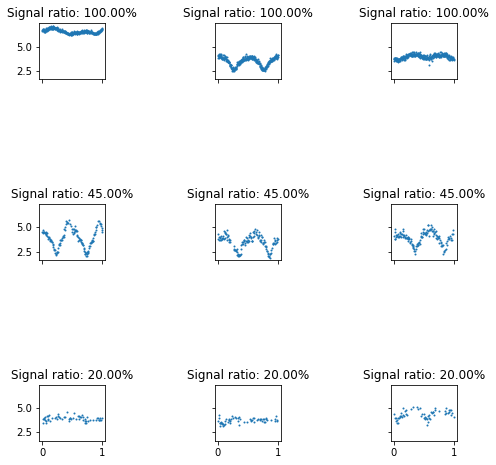

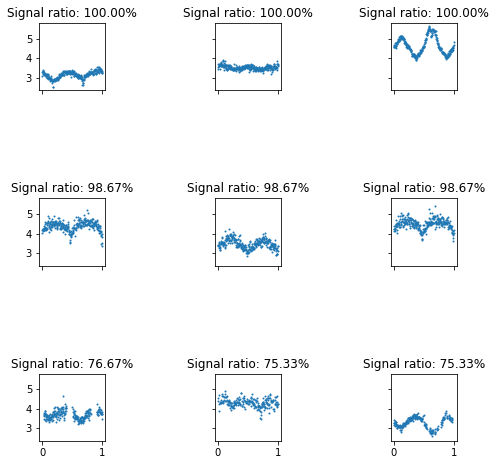

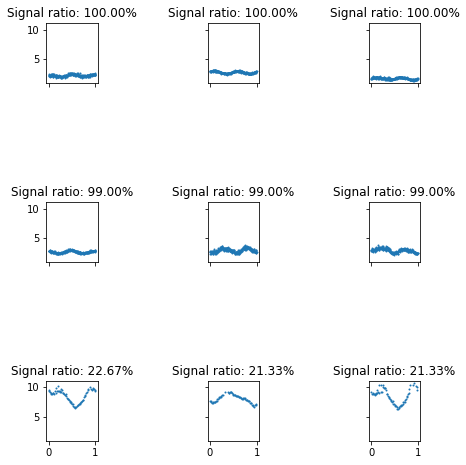

In [10]:
for obj in representants:
    data, titles = representants[obj]
    plot_curves(data, n_cols=3, titles=titles, save_path=f'C:\\Users\\danok\\work\\dizertacka\\plots\\lc_f2_{obj}.png')

# Training

In [51]:
from nn.dataset import NetDataset

In [12]:
N_BINS = 15
N_GAPS = 0
GAP_SIZE = 0
RATIO = 0.2

In [52]:
def create_datasets(data, validation_split=0.1):
    X = []
    y = []
    labels_id = {"falcon_9":0, "atlas_5":1, "delta_4": 2}

    for obj in data:
        arr = data[obj]
        n = int(len(arr))

        X.extend(arr)
        y.extend([labels_id[obj]]*n)


    X = np.array(X)
    y = np.array(y)

    indices = np.random.permutation(len(X))

    X = X[indices]
    y = y[indices]

    c_train = int(len(X) * validation_split)

    val_set = NetDataset(X[:c_train], y[:c_train])
    train_set = NetDataset(X[c_train:], y[c_train:])

    return train_set, val_set

In [14]:
labeled_data = dict_map(cylinder_data, sort_func)

f_continous = partial(get_filter_continuous, n_bins=N_BINS, gap=N_GAPS, continous_gap=GAP_SIZE)
f_ratio = partial(get_filter_ratio, ratio=RATIO)
app_filters_p = partial(apply_filters, filters_f=[f_continous, f_ratio], operation="AND")

filtered_data = dict_map(labeled_data, app_filters_p)

In [15]:
train_set, val_set = create_datasets(filtered_data, 0.1)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

In [30]:
model = Net("f_heavy_trained", 
            input_size=INPUT_SIZE,
            n_channels=N_CHANNELS,
            hid_dim=HID_DIM,
            n_classes=3,
            stride=STRIDE,  
            kernel=KERNEL_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)   
criterion = nn.NLLLoss()   

In [31]:
model.double()
model.train_model(optimizer, criterion, train_loader, val_loader, 
            epochs=100, save_interval=20)

Epoch 1: : 162it [00:00, 209.28it/s]

72.49732630555819


Accuracy on 1145 examples: 78.60262008733625


Epoch 2: : 162it [00:00, 212.49it/s]

68.69943483247023


Accuracy on 1145 examples: 85.58951965065502


Epoch 3: : 162it [00:00, 213.25it/s]

61.83650848672248


Accuracy on 1145 examples: 80.61135371179039


Epoch 4: : 162it [00:00, 219.49it/s]

52.49034790144847


Accuracy on 1145 examples: 87.59825327510917


Epoch 5: : 162it [00:00, 224.03it/s]

47.41957203464413


Accuracy on 1145 examples: 86.37554585152839


Epoch 6: : 162it [00:00, 208.63it/s]

44.8276580052584


Accuracy on 1145 examples: 87.4235807860262


Epoch 7: : 162it [00:00, 192.46it/s]

43.55999702780782


Accuracy on 1145 examples: 84.62882096069869


Epoch 8: : 162it [00:00, 215.70it/s]

43.3820490536388


Accuracy on 1145 examples: 86.98689956331877


Epoch 9: : 162it [00:00, 219.76it/s]

41.33363872093426


Accuracy on 1145 examples: 87.4235807860262


Epoch 10: : 162it [00:00, 222.21it/s]

38.98102587111455


Accuracy on 1145 examples: 87.86026200873363


Epoch 11: : 162it [00:00, 220.55it/s]

38.331021702460504


Accuracy on 1145 examples: 87.51091703056768


Epoch 12: : 162it [00:00, 226.06it/s]

36.86542072808498


Accuracy on 1145 examples: 86.11353711790393


Epoch 13: : 162it [00:00, 228.02it/s]

36.37205807396376


Accuracy on 1145 examples: 88.5589519650655


Epoch 14: : 162it [00:00, 219.44it/s]

34.84874971274422


Accuracy on 1145 examples: 88.5589519650655


Epoch 15: : 162it [00:00, 220.69it/s]

34.772778890878826


Accuracy on 1145 examples: 87.9475982532751


Epoch 16: : 162it [00:00, 229.41it/s]

33.98041320302453


Accuracy on 1145 examples: 86.63755458515284


Epoch 17: : 162it [00:00, 220.87it/s]

32.12111503283075


Accuracy on 1145 examples: 88.29694323144105


Epoch 18: : 162it [00:00, 217.45it/s]

30.766906962141462


Accuracy on 1145 examples: 88.29694323144105


Epoch 19: : 162it [00:00, 221.32it/s]

29.625958997971548


Accuracy on 1145 examples: 88.12227074235808


Epoch 20: : 162it [00:00, 221.29it/s]

29.32998526341018


Accuracy on 1145 examples: 87.9475982532751


Epoch 21: : 162it [00:00, 208.70it/s]

27.98649421087145


Accuracy on 1145 examples: 88.29694323144105


Epoch 22: : 162it [00:00, 208.99it/s]

28.165957722970145


Accuracy on 1145 examples: 88.29694323144105


Epoch 23: : 162it [00:00, 190.65it/s]

26.220858314076597


Accuracy on 1145 examples: 87.68558951965065


Epoch 24: : 162it [00:00, 194.95it/s]

25.424339461001175


Accuracy on 1145 examples: 87.51091703056768


Epoch 25: : 162it [00:00, 202.60it/s]

24.7203468950952


Accuracy on 1145 examples: 87.59825327510917


Epoch 26: : 162it [00:00, 228.14it/s]

24.05050040738499


Accuracy on 1145 examples: 86.8122270742358


Epoch 27: : 162it [00:00, 231.99it/s]

23.31152338826568


Accuracy on 1145 examples: 87.9475982532751


Epoch 28: : 162it [00:00, 218.14it/s]

23.290557182577402


Accuracy on 1145 examples: 87.16157205240175


Epoch 29: : 162it [00:00, 219.16it/s]

22.75023956953115


Accuracy on 1145 examples: 86.98689956331877


Epoch 30: : 162it [00:00, 200.53it/s]

21.035493432361285


Accuracy on 1145 examples: 87.16157205240175


Epoch 31: : 162it [00:00, 218.36it/s]

20.50046866586982


Accuracy on 1145 examples: 87.33624454148472


Epoch 32: : 162it [00:00, 217.17it/s]

19.95321407229453


Accuracy on 1145 examples: 86.55021834061135


Epoch 33: : 162it [00:00, 217.74it/s]

19.732033885818925


Accuracy on 1145 examples: 87.59825327510917


Epoch 34: : 162it [00:00, 219.45it/s]

18.70225783233715


Accuracy on 1145 examples: 87.68558951965065


Epoch 35: : 162it [00:00, 214.94it/s]

19.053876282263136


Accuracy on 1145 examples: 87.51091703056768


Epoch 36: : 162it [00:00, 224.63it/s]

17.694306818919046


Accuracy on 1145 examples: 87.33624454148472


Epoch 37: : 162it [00:00, 210.03it/s]

17.524331118116116


Accuracy on 1145 examples: 87.86026200873363


Epoch 38: : 162it [00:00, 209.24it/s]

16.625294285616338


Accuracy on 1145 examples: 87.86026200873363


Epoch 39: : 162it [00:00, 214.92it/s]

15.65199930564664


Accuracy on 1145 examples: 88.12227074235808


Epoch 40: : 162it [00:00, 218.76it/s]

15.836124969359108


Accuracy on 1145 examples: 88.0349344978166


Epoch 41: : 162it [00:00, 208.75it/s]

15.526020485562835


Accuracy on 1145 examples: 88.0349344978166


Epoch 42: : 162it [00:00, 192.56it/s]

14.609893234209967


Accuracy on 1145 examples: 87.59825327510917


Epoch 43: : 162it [00:00, 191.25it/s]

14.73501340092137


Accuracy on 1145 examples: 87.68558951965065


Epoch 44: : 162it [00:00, 201.23it/s]

17.836791921152678


Accuracy on 1145 examples: 87.86026200873363


Epoch 45: : 162it [00:00, 214.17it/s]

14.140633716304304


Accuracy on 1145 examples: 88.0349344978166


Epoch 46: : 162it [00:00, 191.84it/s]

14.12476932002578


Accuracy on 1145 examples: 87.16157205240175


Epoch 47: : 162it [00:00, 203.61it/s]

14.260872989324842


Accuracy on 1145 examples: 87.07423580786026


Epoch 48: : 162it [00:00, 210.94it/s]

12.998431774299592


Accuracy on 1145 examples: 87.24890829694323


Epoch 49: : 162it [00:00, 209.60it/s]

12.790229803446339


Accuracy on 1145 examples: 87.77292576419214


Epoch 50: : 162it [00:00, 203.77it/s]

12.220549054124072


Accuracy on 1145 examples: 87.4235807860262


Epoch 51: : 162it [00:00, 205.16it/s]

11.7765525285796


Accuracy on 1145 examples: 87.24890829694323


Epoch 52: : 162it [00:00, 215.43it/s]

11.722384982640548


Accuracy on 1145 examples: 88.646288209607


Epoch 53: : 162it [00:00, 210.13it/s]

11.711437966523832


Accuracy on 1145 examples: 87.77292576419214


Epoch 54: : 162it [00:00, 202.53it/s]

11.191018089209692


Accuracy on 1145 examples: 87.51091703056768


Epoch 55: : 162it [00:00, 212.89it/s]

10.879056339117815


Accuracy on 1145 examples: 86.72489082969432


Epoch 56: : 162it [00:00, 204.27it/s]

17.935266838263342


Accuracy on 1145 examples: 88.38427947598254


Epoch 57: : 162it [00:00, 207.97it/s]

14.251207311343228


Accuracy on 1145 examples: 86.8995633187773


Epoch 58: : 162it [00:00, 212.61it/s]

11.410855402776143


Accuracy on 1145 examples: 88.29694323144105


Epoch 59: : 162it [00:00, 212.33it/s]

10.930273333824617


Accuracy on 1145 examples: 87.51091703056768


Epoch 60: : 162it [00:00, 209.04it/s]

10.32475244277015


Accuracy on 1145 examples: 88.12227074235808


Epoch 61: : 162it [00:00, 209.53it/s]

9.687901963616254


Accuracy on 1145 examples: 87.16157205240175


Epoch 62: : 162it [00:00, 199.30it/s]

9.483053230591809


Accuracy on 1145 examples: 87.68558951965065


Epoch 63: : 162it [00:00, 186.42it/s]

9.552845033085186


Accuracy on 1145 examples: 87.77292576419214


Epoch 64: : 162it [00:00, 185.00it/s]

9.496968916401775


Accuracy on 1145 examples: 87.59825327510917


Epoch 65: : 162it [00:00, 201.78it/s]

9.154575970921801


Accuracy on 1145 examples: 87.68558951965065


Epoch 66: : 162it [00:00, 209.58it/s]

9.052775886679944


Accuracy on 1145 examples: 88.5589519650655


Epoch 67: : 162it [00:00, 204.76it/s]

10.511529617316834


Accuracy on 1145 examples: 87.68558951965065


Epoch 68: : 162it [00:00, 207.71it/s]

9.157972928124904


Accuracy on 1145 examples: 88.0349344978166


Epoch 69: : 162it [00:00, 209.86it/s]

9.084665470099344


Accuracy on 1145 examples: 87.07423580786026


Epoch 70: : 162it [00:00, 208.25it/s]

9.352471170436038


Accuracy on 1145 examples: 87.9475982532751


Epoch 71: : 162it [00:00, 212.21it/s]

8.736516260436684


Accuracy on 1145 examples: 87.24890829694323


Epoch 72: : 162it [00:00, 206.57it/s]

8.340892510840996


Accuracy on 1145 examples: 87.59825327510917


Epoch 73: : 162it [00:00, 207.45it/s]

8.041826519565374


Accuracy on 1145 examples: 87.33624454148472


Epoch 74: : 162it [00:00, 201.99it/s]

7.63761079945262


Accuracy on 1145 examples: 87.4235807860262


Epoch 75: : 162it [00:00, 212.89it/s]

7.571737621843899


Accuracy on 1145 examples: 86.98689956331877


Epoch 76: : 162it [00:00, 202.28it/s]

7.517009008395609


Accuracy on 1145 examples: 88.29694323144105


Epoch 77: : 162it [00:00, 210.94it/s]

7.378325541409318


Accuracy on 1145 examples: 87.33624454148472


Epoch 78: : 162it [00:00, 200.21it/s]

7.733216682523936


Accuracy on 1145 examples: 88.5589519650655


Epoch 79: : 162it [00:00, 209.31it/s]

7.30190089207318


Accuracy on 1145 examples: 88.47161572052401


Epoch 80: : 162it [00:00, 207.97it/s]

7.022562466861909


Accuracy on 1145 examples: 87.77292576419214


Epoch 81: : 162it [00:00, 203.02it/s]

6.839013134897969


Accuracy on 1145 examples: 87.68558951965065


Epoch 82: : 162it [00:00, 199.54it/s]

7.676993736190449


Accuracy on 1145 examples: 87.4235807860262


Epoch 83: : 162it [00:00, 183.85it/s]

13.228009792261577


Accuracy on 1145 examples: 88.20960698689956


Epoch 84: : 162it [00:00, 189.76it/s]

8.032665404817775


Accuracy on 1145 examples: 87.9475982532751


Epoch 85: : 162it [00:00, 209.75it/s]

9.545890526745307


Accuracy on 1145 examples: 87.24890829694323


Epoch 86: : 162it [00:00, 207.26it/s]

6.614770986570902


Accuracy on 1145 examples: 88.0349344978166


Epoch 87: : 162it [00:00, 208.04it/s]

6.602329595147295


Accuracy on 1145 examples: 87.33624454148472


Epoch 88: : 162it [00:00, 202.79it/s]

6.493365676373618


Accuracy on 1145 examples: 88.5589519650655


Epoch 89: : 162it [00:00, 203.03it/s]

6.392185562319404


Accuracy on 1145 examples: 87.77292576419214


Epoch 90: : 162it [00:00, 205.08it/s]

6.203973202352095


Accuracy on 1145 examples: 87.77292576419214


Epoch 91: : 162it [00:00, 211.23it/s]

5.9348306034184155


Accuracy on 1145 examples: 88.20960698689956


Epoch 92: : 162it [00:00, 213.53it/s]

6.076795002965595


Accuracy on 1145 examples: 87.24890829694323


Epoch 93: : 162it [00:00, 207.80it/s]

5.8344227749937225


Accuracy on 1145 examples: 88.73362445414847


Epoch 94: : 162it [00:00, 209.47it/s]

5.795676747514494


Accuracy on 1145 examples: 87.86026200873363


Epoch 95: : 162it [00:00, 218.56it/s]

5.74829257666463


Accuracy on 1145 examples: 88.38427947598254


Epoch 96: : 162it [00:00, 207.44it/s]

6.682295679712093


Accuracy on 1145 examples: 88.12227074235808


Epoch 97: : 162it [00:00, 197.48it/s]

7.204396529464528


Accuracy on 1145 examples: 87.24890829694323


Epoch 98: : 162it [00:00, 194.06it/s]

5.754040433433112


Accuracy on 1145 examples: 87.68558951965065


Epoch 99: : 162it [00:00, 200.11it/s]

5.573460489413138


Accuracy on 1145 examples: 88.29694323144105


Epoch 100: : 162it [00:00, 207.97it/s]

5.5082414293536806
Accuracy on 1145 examples: 88.12227074235808


In [32]:
model.save()

In [27]:
from nn.net import evaulate_net

In [33]:
evaulate_net(model, val_loader)

Accuracy on 1145 examples: 88.12227074235808


88.12227074235808

In [34]:
evaulate_net(model, train_loader)

Accuracy on 10308 examples: 98.7000388048118


98.7000388048118

# New Filter finding konstants

In [5]:
import sys

sys.path.append("../")
sys.path.append("../../")

from utils.data_load import (load_data, dict_map, get_representants, 
                                get_non_zero_ratio, sort_func, get_stats, get_labeled_data)
from utils.filters import filter_data
from nn.config import *
from nn.net import Net, evaulate_net
from nn.dataset import NetDataset, create_datasets
from utils.plot_light_curve import plot_curves
import numpy as np

In [9]:
raw_data = load_data(DATA_PATH)

Folder c:/Users/danok/work/dizertacka/resources/Fall_2021_2: 100%|██████████| 495/495 [00:07<00:00, 69.67it/s] 


In [37]:
def normalize_f(data):
    std = [ np.std(d[d!=0]) for d in data]
    mean = [np.mean(d[d!=0]) for d in data]

    normalized = np.empty(data.shape, dtype=np.float32)

    for i, d in enumerate(data):
        normalized[i] = d.copy()
        if std[i] != 0:
            normalized[i][d!=0] = (normalized[i][d!=0] - mean[i]) / std[i]

    return normalized

def flip_f(data):
    return -data

In [33]:
cylinder_data = get_labeled_data(raw_data, OBJECTS["cylinder"])

In [34]:
normalized_data = dict_map(cylinder_data, normalize_f)

In [38]:
filter_config = FilterConfig(
    n_bins=15,
    n_gaps=4, 
    gap_size=2,  
    non_zero_ratio=0.2
)
fliped_data = dict_map(normalized_data, flip_f)
filtered_data = filter_data(fliped_data, filter_config)

atlas_5, total: 19509, filter: 11384, 58.35%


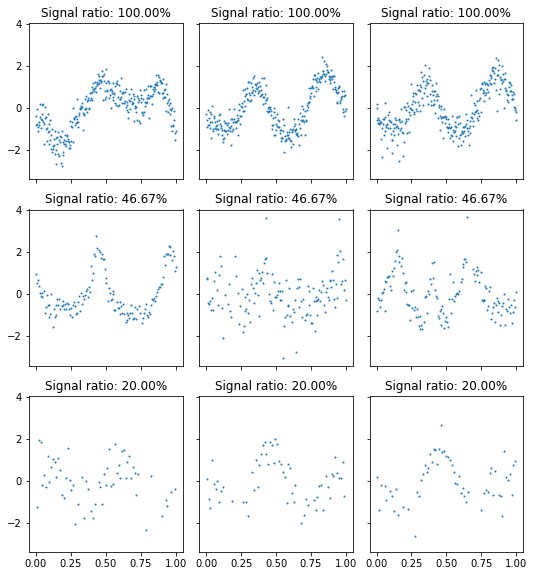

delta_4, total: 2750, filter: 737, 26.80%


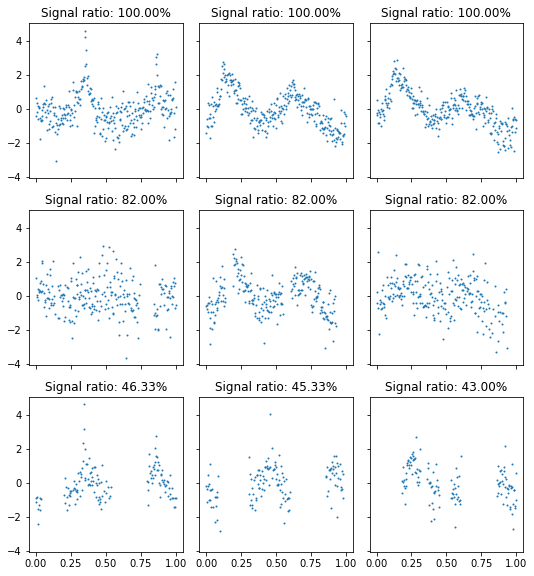

falcon_9, total: 5861, filter: 3507, 59.84%


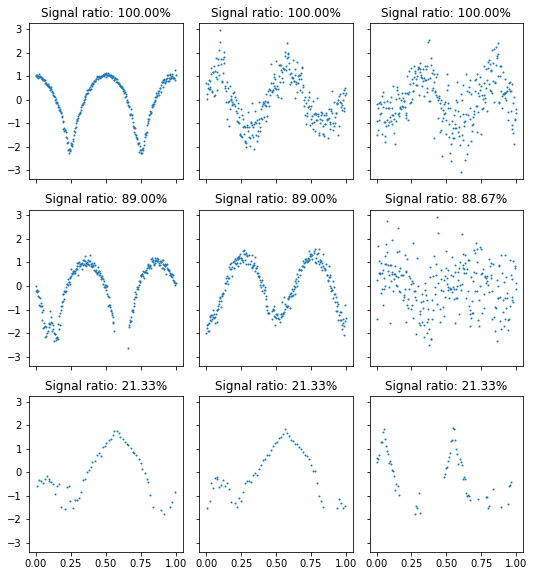

In [39]:
sorted_data = dict_map(filtered_data, sort_func)
representants = dict_map(sorted_data, get_representants)

for obj in representants:
    print(f"{obj}, total: {len(cylinder_data[obj])}, filter: {len(filtered_data[obj])}, "
          f"{len(filtered_data[obj])/len(cylinder_data[obj]) * 100:.2f}%")
    data, titles = representants[obj]
    plot_curves(data, n_cols=3, titles=titles)

invertnut Y os

+ pozriet normalizaciu

SAJA

La rioja

+ pozriet Univerzitu s nejakym zamerom

In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

In [2]:
from utils.config import *

In [3]:
load_config()

{'name': 'best', 'checkpoint': 'latest', 'input_size': 300, 'n_channels': 10, 'n_classes': 3, 'hid_dim': 128, 'stride': 2, 'kernel_size': 5}


(DataConfig(path={'path': 'c:/Users/danok/work/dizertacka/resources/Fall_2021_2', 'labels': {'cylinder': ['falcon_9', 'atlas_5', 'delta_4'], 'boxwing': ['navstar', 'giove', 'beidou', 'astra', 'meteosat', 'globstar', 'intelsat'], 'nonsymetric': ['iridium', 'orbcomm']}}, labels={'cylinder': ['falcon_9', 'atlas_5', 'delta_4'], 'boxwing': ['navstar', 'giove', 'beidou', 'astra', 'meteosat', 'globstar', 'intelsat'], 'nonsymetric': ['iridium', 'orbcomm']}),
 NetConfig(name='best', checkpoint='latest', input_size=300, n_channels=10, n_classes=3, hid_dim=128, stride=2, kernel_size=5),
 FilterConfig(n_bins=15, n_gaps=0, gap_size=0, non_zero_ratio=0.2))